___
# Simulations for local ancestry PRS
___

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sys
import gzip
import multiprocessing as mp
import glob
import numpy as np
import h5py
from scipy import stats
import msprime

In [2]:
sys.path.insert(0,"/Users/taylorcavazos/repos/Local_Ancestry_PRS/code/")

In [3]:
import pandas as pd

In [4]:
m = 1000
h2 = 0.67
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_sub_CEU_1.95e5.hdf"
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_YRI_5e4_CEU_2e5_chr22.hdf5"

In [5]:
def load_data(sim):
    sim_dict = {}
    
    prs_anc = pd.read_csv("../results/sim{}/admix_afr_amer_m_1000_h2_0.67_r2_0.2_p_0.01.prop.anc.PRS".format(sim),sep="\t",index_col=0)
    total_anc = pd.read_csv("../results/sim{}/admix_afr_amer.prop.anc".format(sim),sep="\t",index_col=0)
    sim_dict["PRS_ANC"] = prs_anc
    sim_dict["TOTAL_ANC"] = total_anc
    
    sum_stats = pd.read_csv("../results/sim{}/emp_prs/comm_maf_0.01_sum_stats_m_1000_h2_0.67.txt".format(sim),index_col=0,sep="\t")
    emp_prs = h5py.File("../results/sim{}/emp_prs/emp_prs_m_1000_h2_0.67_ld_CEU_GWAS_r2_0.2_p0.01.hdf5".format(sim),"r")
    prs_vars = np.loadtxt("../results/sim{}/emp_prs/clumped_prs_vars_m_1000_h2_0.67_ld_CEU_GWAS_r2_0.2_p0.01.txt".format(sim))
    sim_dict["SS"] = sum_stats
    sim_dict["EMP_PRS"] = emp_prs
    sim_dict["PRS_VARS"] = prs_vars
    
    true_prs = h5py.File("../results/sim{}/true_prs/prs_m_1000_h2_0.67.hdf5".format(sim),"r")
    labels = h5py.File("../results/sim{}/true_prs/train_test_m_1000_h2_0.67.hdf5".format(sim),"r")
    sim_dict["TRUE_PRS"] = true_prs
    sim_dict["LABELS"] = labels
    
    return sim_dict

In [6]:
sim = load_data(2)

In [7]:
sns.set_context("talk")
sns.set_style("ticks")

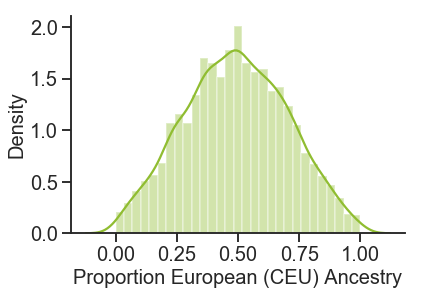

In [8]:
sns.distplot(sim["TOTAL_ANC"].loc[:,"Prop_CEU"],color="#90bd31")
plt.xlabel("Proportion European (CEU) Ancestry",fontsize=20)
plt.ylabel("Density",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.savefig("/Users/taylorcavazos/Desktop/prop_CEU.pdf",type="pdf",bbox_inches="tight")
plt.show()

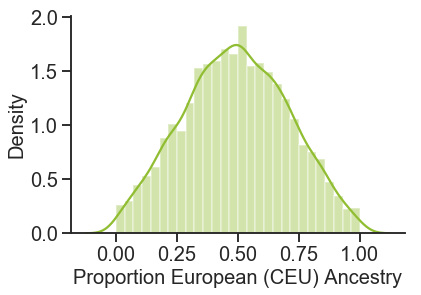

In [9]:
sns.distplot(sim["PRS_ANC"].loc[:,"Prop_CEU"],color="#90bd31")
plt.xlabel("Proportion European (CEU) Ancestry",fontsize=20)
plt.ylabel("Density",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()

In [10]:
sim["TRUE_PRS"].keys()

<KeysViewHDF5 ['G', 'X', 'Zx', 'labels']>

In [11]:
test_locs = sim["LABELS"]["test_data"][()]

In [12]:
true_prs_labels = sim["TRUE_PRS"]["labels"][()]
test_locs_ceu = []
test_locs_admix = []
for ind in test_locs:
    if "msp" in true_prs_labels[ind].astype(str):
        test_locs_ceu.append(ind)
    else:
        test_locs_admix.append(ind)
test_locs_ceu = np.array(test_locs_ceu)
test_locs_admix = np.array(test_locs_admix)

In [13]:
msp_inds = []
other_inds = []
count = 0
for ind in sim["TRUE_PRS"]["labels"][()].astype(str):
    if "msp" in ind:
        msp_inds.append(count)
    else: other_inds.append(count)
    count+=1

In [14]:

sns.distplot(true_prs_std[msp_inds],color="black",label="European")
sns.distplot(true_prs_std[other_inds],color="gray",label="Admixed")
plt.show()

NameError: name 'true_prs_std' is not defined

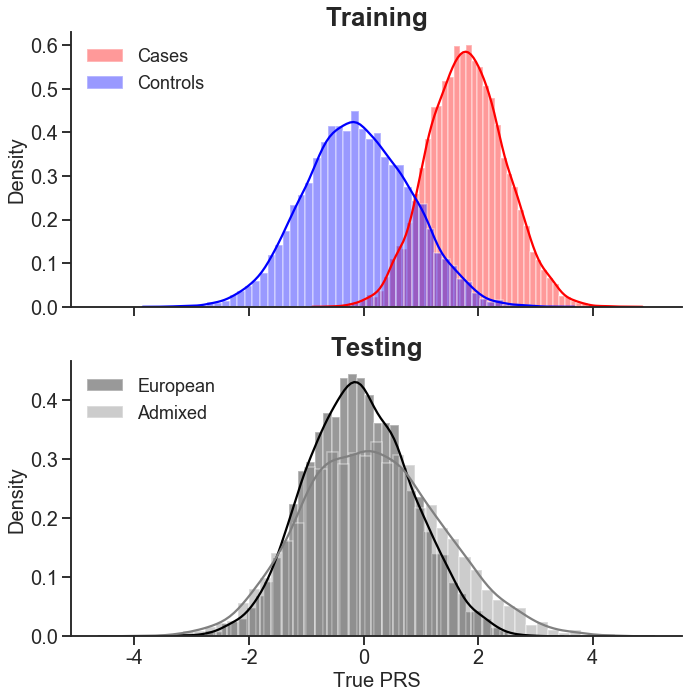

In [15]:
true_prs = sim["TRUE_PRS"]["X"][()]
true_prs_std = stats.zscore(true_prs)
#true_prs_std = (true_prs - true_prs.min())/(true_prs.max()-true_prs.min())
case_prs = true_prs_std[sim["LABELS"]["train_cases"][()]]
control_prs = true_prs_std[sim["LABELS"]["train_controls"][()]]
test_prs_ceu = true_prs_std[test_locs_ceu]
test_prs_admix = true_prs_std[test_locs_admix]

fig,axes = plt.subplots(ncols=1,nrows=2,figsize=(10,10),sharex=True)

sns.distplot(case_prs,color="red",label="Cases",ax=axes[0])
sns.distplot(control_prs,color="blue",label="Controls",ax=axes[0])

axes[0].set_title("Training",fontsize=26,fontweight="bold")
#axes[0].set_xlabel("True PRS",fontsize=20)
axes[0].set_ylabel("Density",fontsize=20)
axes[0].set_xticklabels(axes[0].get_xticks(),fontsize=20)
axes[0].set_yticklabels(np.round(axes[0].get_yticks(),2),fontsize=20)
axes[0].legend(frameon=False,fontsize=18,loc=2)

sns.distplot(test_prs_ceu,color="black",label="European",ax=axes[1])
sns.distplot(test_prs_admix,color="gray",label="Admixed",ax=axes[1])

axes[1].set_title("Testing",fontsize=26,fontweight="bold")
axes[1].set_xlabel("True PRS",fontsize=20)
axes[1].set_ylabel("Density",fontsize=20)
axes[1].set_xticklabels(axes[0].get_xticks().astype(int),fontsize=20)
axes[1].set_yticklabels(np.round(axes[0].get_yticks(),2),fontsize=20)
axes[1].legend(frameon=False,fontsize=18,loc=2)


sns.despine()
plt.tight_layout(pad=1)
plt.savefig("/Users/taylorcavazos/Desktop/true_prs.pdf",type="pdf")
plt.show()

In [16]:
sig_sum_stats = sim["SS"].loc[sim["PRS_VARS"].astype(int)]

In [17]:
sig_sum_stats[sig_sum_stats["OR"] == 0] = 1

In [18]:
sig_sum_stats["logOR"] = np.log(sig_sum_stats["OR"])

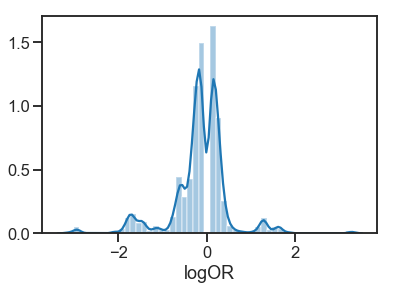

In [19]:
sns.distplot(sig_sum_stats["logOR"])
plt.show()

In [20]:
case_prs = sim["EMP_PRS"]["X"][()][sim["LABELS"]["train_cases"][()]]

In [21]:
control_prs = sim["EMP_PRS"]["X"][()][sim["LABELS"]["train_controls"][()]]

In [22]:
sim2_tree_gwas = msprime.load("../results/sim2/trees/tree_CEU_GWAS_nofilt.hdf")

In [23]:
sim2_tree_gwas.sites()

<generator object TreeSequence.sites at 0x7fdb017b1750>

In [24]:
import itertools
top5 = itertools.islice(sim2_tree_gwas.variants(), 5)

In [25]:
elem = list(top5)

In [26]:
elem[0].site.id

0

In [27]:
num_sites = sim2_tree_gwas.num_sites

In [28]:
causal_inds = np.linspace(0, num_sites, m, dtype=int,endpoint=False)

In [29]:
set(causal_inds).intersection(sig_sum_stats.index)

{511621,
 542472,
 832991,
 854844,
 893409,
 925546,
 931973,
 939686,
 989820,
 993676,
 1086231}

In [30]:
sig_sum_stats.index

Int64Index([     27,  186402,  328631,  328597,  187650,  329268,  210622,
             196911,  146227,  146611,
            ...
             671719,  878089,  591708, 1210244,  948955,  722803,  735686,
             960708,  453032, 1174168],
           dtype='int64', name='var_id', length=2295)

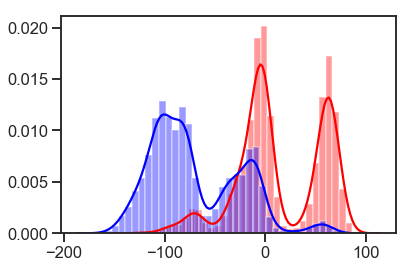

In [31]:
sns.distplot(case_prs,color="red")
sns.distplot(control_prs,color="blue")
plt.show()

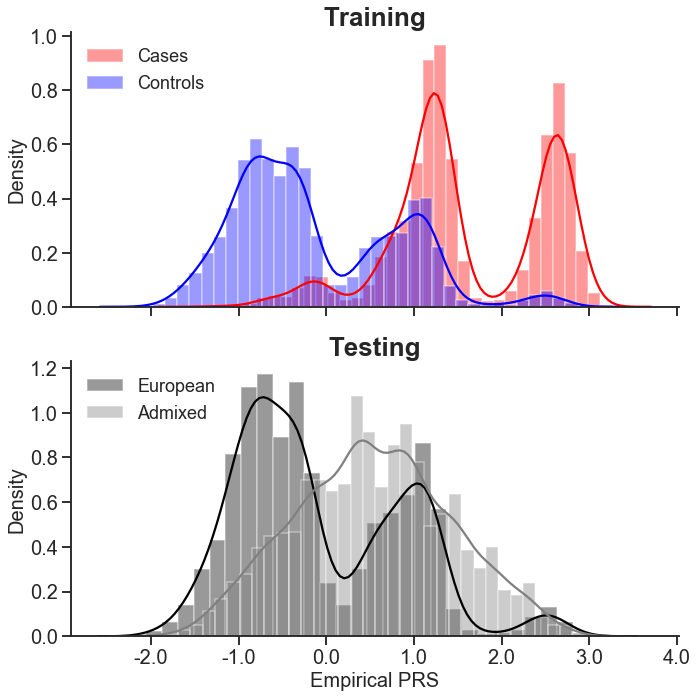

In [32]:
emp_prs = sim["EMP_PRS"]["X"][()]
emp_prs_std = stats.zscore(emp_prs)
#emp_prs_std = (emp_prs - emp_prs.min())/(emp_prs.max()-emp_prs.min())
case_prs = emp_prs_std[sim["LABELS"]["train_cases"][()]]
control_prs = emp_prs_std[sim["LABELS"]["train_controls"][()]]
test_prs_ceu = emp_prs_std[test_locs_ceu]
test_prs_admix = emp_prs_std[test_locs_admix]

fig,axes = plt.subplots(ncols=1,nrows=2,figsize=(10,10),sharex=True)

sns.distplot(case_prs,color="red",label="Cases",ax=axes[0])
sns.distplot(control_prs,color="blue",label="Controls",ax=axes[0])

axes[0].set_title("Training",fontsize=26,fontweight="bold")
#axes[0].set_xlabel("True PRS",fontsize=20)
axes[0].set_ylabel("Density",fontsize=20)
axes[0].set_xticklabels(np.round(axes[0].get_xticks(),2),fontsize=20)
axes[0].set_yticklabels(np.round(axes[0].get_yticks(),2),fontsize=20)
axes[0].legend(frameon=False,fontsize=18,loc=2)

sns.distplot(test_prs_ceu,color="black",label="European",ax=axes[1])
sns.distplot(test_prs_admix,color="gray",label="Admixed",ax=axes[1])

axes[1].set_title("Testing",fontsize=26,fontweight="bold")
axes[1].set_xlabel("Empirical PRS",fontsize=20)
axes[1].set_ylabel("Density",fontsize=20)
axes[1].set_xticklabels(np.round(axes[0].get_xticks(),2),fontsize=20)
axes[1].set_yticklabels(np.round(axes[0].get_yticks(),2),fontsize=20)
axes[1].legend(frameon=False,fontsize=18,loc=2)


sns.despine()
plt.tight_layout(pad=1)
plt.show()

In [33]:
len(sim["PRS_VARS"])

2295

In [34]:
def output_corr(inds):
    corr,pval = stats.spearmanr(emp_prs_std[test_locs_admix[inds]], true_prs_std[test_locs_admix[inds]])
    return corr

In [35]:
def anc_stuff(low, high):
    anc_w_ind = sim["PRS_ANC"].reset_index()
    low_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]<=low].index)
    mid_eur = np.array(anc_w_ind[(anc_w_ind["Prop_CEU"]>low)&(anc_w_ind["Prop_CEU"]<high)].index)
    high_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]>=high].index)
    
    print("Low = {}, High = {}".format(low,high))
    print("-------------------")
    print("Number in group: low CEU = {}, mid CEU = {}, high CEU = {}".format(len(low_eur),len(mid_eur),len(high_eur)))
    low_corr = output_corr(low_eur)
    mid_corr = output_corr(mid_eur)
    high_corr = output_corr(high_eur)
    print("Correlation per group: low CEU = {}, mid CEU = {}, hgih CEU = {}".format(low_corr,mid_corr,high_corr))

In [36]:
anc_stuff(0.2,0.8)

Low = 0.2, High = 0.8
-------------------
Number in group: low CEU = 474, mid CEU = 4105, high CEU = 421
Correlation per group: low CEU = 0.5314971132705048, mid CEU = 0.5818339647356673, hgih CEU = 0.7568461460526168


In [37]:
anc_stuff(0.2,0.8)

Low = 0.2, High = 0.8
-------------------
Number in group: low CEU = 474, mid CEU = 4105, high CEU = 421
Correlation per group: low CEU = 0.5314971132705048, mid CEU = 0.5818339647356673, hgih CEU = 0.7568461460526168


In [38]:
anc_w_ind = sim["PRS_ANC"].reset_index()
low_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]<=0.2].index)
mid_eur = np.array(anc_w_ind[(anc_w_ind["Prop_CEU"]>0.2)&(anc_w_ind["Prop_CEU"]<=0.8)].index)
high_eur = np.array(anc_w_ind[anc_w_ind["Prop_CEU"]>0.8].index)

In [39]:
emp_prs_std = stats.zscore(emp_prs)

In [40]:
len(low_eur)

474

In [41]:
len(mid_eur)

4105

In [42]:
len(high_eur)

421

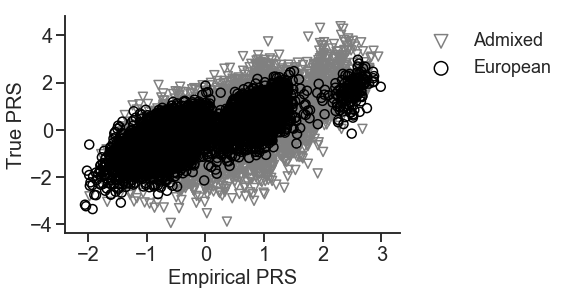

In [43]:
plt.scatter(emp_prs_std[test_locs_admix], true_prs_std[test_locs_admix],edgecolor="gray",facecolor="none",label="Admixed",marker="v")
plt.scatter(emp_prs_std[test_locs_ceu], true_prs_std[test_locs_ceu],edgecolor="black",facecolor="none",label="European")
plt.legend(frameon=False,loc=1,bbox_to_anchor=(1.5,1),fontsize=18,markerscale=1.5)
plt.xlabel("Empirical PRS",fontsize=20)
plt.ylabel("True PRS",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.savefig("/Users/taylorcavazos/Desktop/corr_emp_true.pdf",type="pdf",bbox_inches="tight")
plt.show()

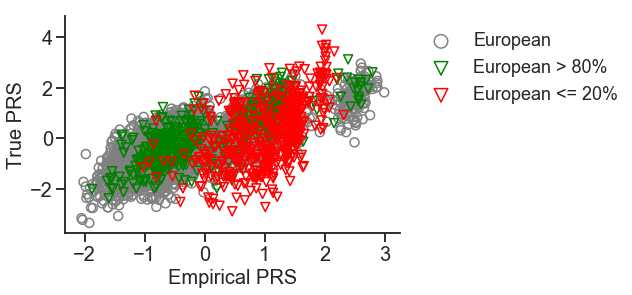

In [44]:
plt.scatter(emp_prs_std[test_locs_ceu], true_prs_std[test_locs_ceu],edgecolor="gray",facecolor="none",label="European")
plt.scatter(emp_prs_std[test_locs_admix[high_eur]], true_prs_std[test_locs_admix[high_eur]],edgecolor="green",facecolor="none",label="European > 80%",marker="v")
plt.scatter(emp_prs_std[test_locs_admix[low_eur]], true_prs_std[test_locs_admix[low_eur]],edgecolor="red",facecolor="none",label="European <= 20%",marker="v")
plt.legend(frameon=False,loc=1,bbox_to_anchor=(1.7,1),fontsize=18,markerscale=1.5)
plt.xlabel("Empirical PRS",fontsize=20)
plt.ylabel("True PRS",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()

Make these plots for all sims

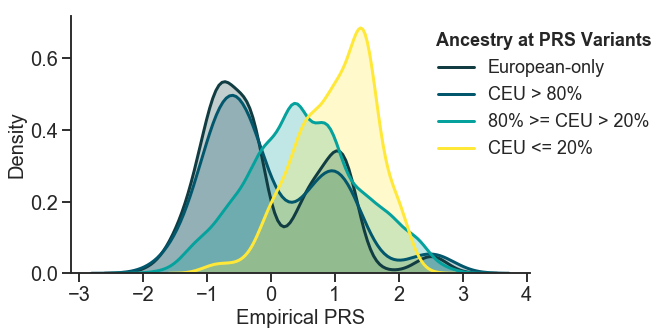

In [46]:
plt.figure(figsize=(10,5))
sns.distplot(emp_prs_std[test_locs_ceu],color="#103c42",label="European-only",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

sns.distplot(emp_prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU > 80%",
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

sns.distplot(emp_prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% >= CEU > 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

sns.distplot(emp_prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

plt.xlabel("Empirical PRS",fontsize=20)
plt.ylabel("Density",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
leg = plt.legend(frameon=False,loc=1,bbox_to_anchor=(1.3,1),fontsize=18)
leg.set_title(title="Ancestry at PRS Variants",prop={"weight":"bold","size":18})
plt.tight_layout()
plt.savefig("/Users/taylorcavazos/Desktop/emp_p0.01_anc_prs.pdf",type="pdf")
plt.show()

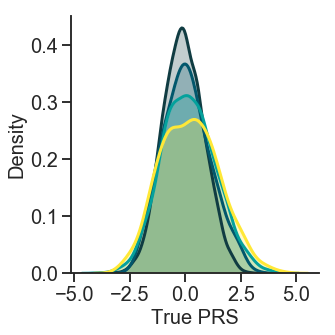

In [124]:
plt.figure(figsize=(5,5))
sns.distplot(true_prs_std[test_locs_ceu],color="#103c42",label="European-only",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

sns.distplot(true_prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU >= 80%",
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

sns.distplot(true_prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% > CEU > 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

sns.distplot(true_prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3})

plt.xlabel("True PRS",fontsize=20)
plt.ylabel("Density",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
#plt.legend(frameon=False,loc=1,bbox_to_anchor=(1.3,1),fontsize=18)
plt.legend().remove()
plt.tight_layout()
plt.savefig("/Users/taylorcavazos/Desktop/true_prs_prs_anc.pdf",type="pdf")
plt.show()

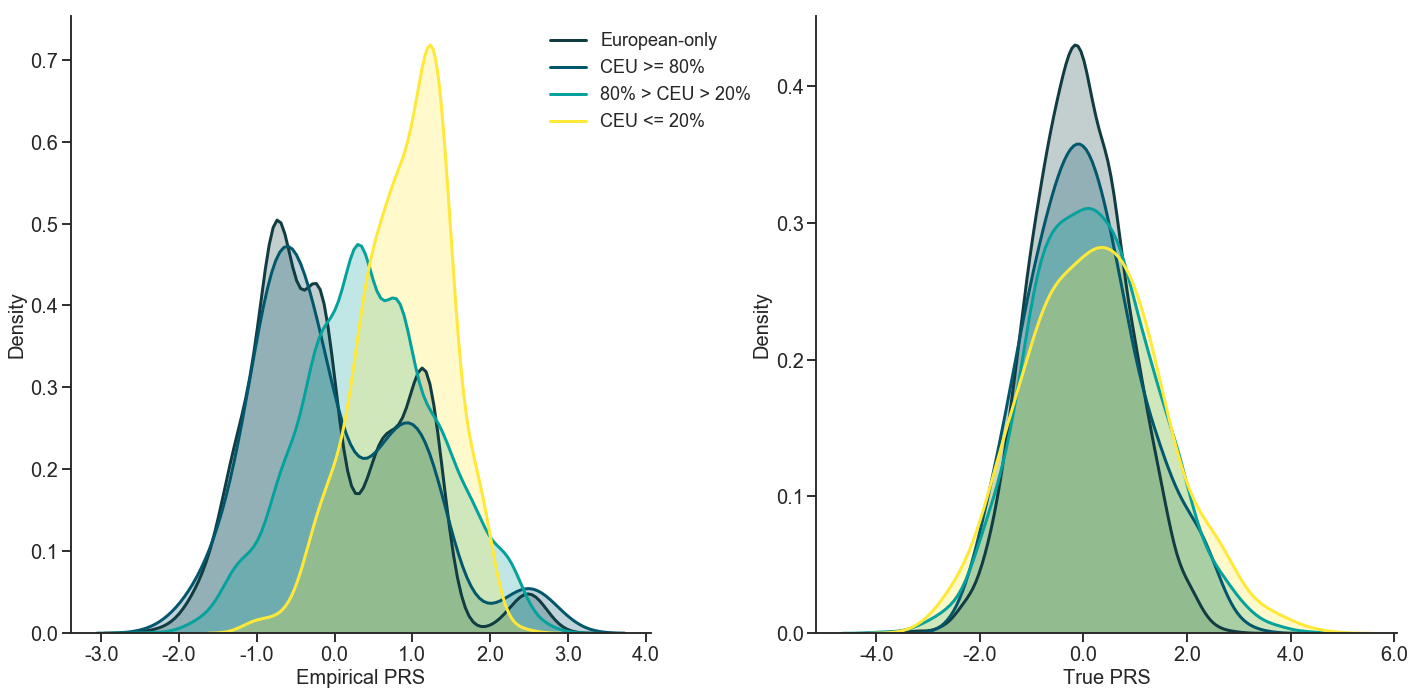

In [150]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(20,10))

sns.distplot(emp_prs_std[test_locs_ceu],color="#103c42",label="European-only",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[0])

sns.distplot(emp_prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU >= 80%",
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[0])

sns.distplot(emp_prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% > CEU > 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[0])

sns.distplot(emp_prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[0])

axes[0].set_xlabel("Empirical PRS",fontsize=20)
axes[0].set_ylabel("Density",fontsize=20)
axes[0].set_xticklabels(axes[0].get_xticks(),fontsize=20)
axes[0].set_yticklabels(np.round(axes[0].get_yticks(),2),fontsize=20)

axes[0].legend(frameon=False,loc=1,bbox_to_anchor=(1.2,1),fontsize=18)



sns.distplot(true_prs_std[test_locs_ceu],color="#103c42",label="European-only",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])

sns.distplot(true_prs_std[test_locs_admix[high_eur]],color="#02576c",label="CEU >= 80%",
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])

sns.distplot(true_prs_std[test_locs_admix[mid_eur]],color="#05a19c",label="80% > CEU > 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])

sns.distplot(true_prs_std[test_locs_admix[low_eur]],color="#ffe837",label="CEU <= 20%",
            hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 3},ax=axes[1])

axes[1].set_xlabel("True PRS",fontsize=20)
axes[1].set_ylabel("Density",fontsize=20)
axes[1].set_xticklabels(axes[1].get_xticks(),fontsize=20)
axes[1].set_yticklabels(np.round(axes[1].get_yticks(),2),fontsize=20)
axes[1].legend().remove()

fig.tight_layout(h_pad= 2,w_pad=0.5)
sns.despine()
plt.show()

In [79]:
stats.ttest_ind(true_prs_std[test_locs_ceu],true_prs_std[test_locs_admix[high_eur]],equal_var=False)

Ttest_indResult(statistic=-2.0401864709698128, pvalue=0.04194396409040209)

In [80]:
stats.ttest_ind(true_prs_std[test_locs_ceu],true_prs_std[test_locs_admix[mid_eur]],equal_var=False)

Ttest_indResult(statistic=-10.641273173435588, pvalue=2.913969153560535e-26)

In [81]:
stats.ttest_ind(true_prs_std[test_locs_ceu],true_prs_std[test_locs_admix[low_eur]],equal_var=False)

Ttest_indResult(statistic=-4.904438291849742, pvalue=1.2986236493221299e-06)

In [82]:
stats.pearsonr(emp_prs_std[test_locs_admix[high_eur]], true_prs_std[test_locs_admix[high_eur]])

(0.7809042708776369, 1.741319640483108e-80)

In [33]:
stats.pearsonr(emp_prs_std[test_locs_admix[mid_eur]], true_prs_std[test_locs_admix[mid_eur]])

(0.5619472368424389, 0.0)

In [34]:
stats.pearsonr(emp_prs_std[test_locs_admix[low_eur]], true_prs_std[test_locs_admix[low_eur]])

(0.6232740633578596, 8.176107590446578e-43)

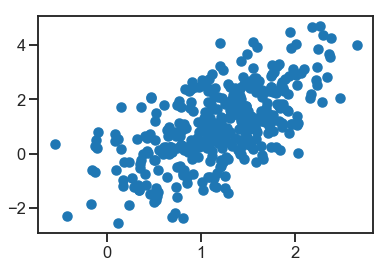

In [35]:
plt.scatter(emp_prs_std[test_locs_admix[low_eur]], true_prs_std[test_locs_admix[low_eur]])

In [36]:
len(sim["PRS_VARS"])

535

# Plot Correlation

### OVERALL ANCESTRY

In [10]:
full_df = pd.DataFrame(columns = ["train_corr","test_EUR_corr","test_ADMIX_corr",
                                 "ADMIX_low_eur_corr","ADMIX_mid_eur_corr","ADMIX_high_eur_corr"])
for f in glob.glob("../results/summary/corrs/summary*"):
    if "PRS" not in f:
        df = pd.read_csv(f,sep="\t",index_col=0)
        df.index = [f.split("_")[-1].split(".")[0]]
        full_df = full_df.append(df,ignore_index=False)

In [11]:
full_df_prs = pd.DataFrame(columns = ["train_corr","test_EUR_corr","test_ADMIX_corr",
                                 "ADMIX_low_eur_corr","ADMIX_mid_eur_corr","ADMIX_high_eur_corr"])
for f in glob.glob("../results/summary/corrs/summary*PRS.txt"):
    df = pd.read_csv(f,sep="\t",index_col=0)
    df.index = [f.split("_")[-1].split(".")[0]]
    full_df_prs = full_df_prs.append(df,ignore_index=False)

In [12]:
full_df.shape

(44, 6)

In [13]:
full_df_prs.shape

(44, 6)

In [14]:
data1 = full_df_prs.loc[:,["test_EUR_corr","ADMIX_high_eur_corr","ADMIX_mid_eur_corr","ADMIX_low_eur_corr"]]

In [15]:
data1.shape

(44, 4)

In [16]:
my_rgbs = np.array(["#103c42","#02576c","#05a19c","#ffe837"])

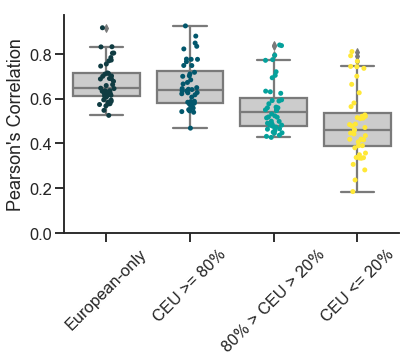

In [17]:
ax = sns.boxplot(data = data1,color=".8")
#ax = sns.boxplot(data = data,palette=my_rgbs)
ax = sns.stripplot(data=data1,jitter=True,palette=my_rgbs,size=5)

ax.set_xticklabels(["European-only","CEU >= 80%","80% > CEU > 20%", "CEU <= 20%"],
                   rotation=45)
ax.set_yticks(np.arange(0,1.0,0.2))
plt.ylabel("Pearson's Correlation")
sns.despine()
plt.show()

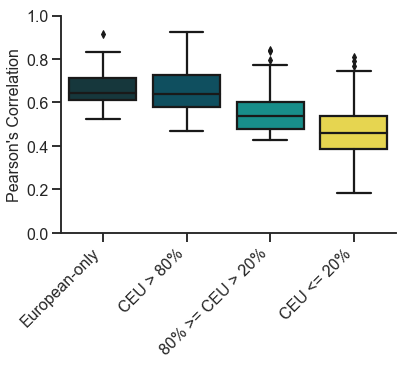

In [18]:
#ax = sns.boxplot(data = data2,color=".8")
# plt.figure(figsize=(8,5))
ax = sns.boxplot(data = data1,palette=my_rgbs)
#ax = sns.stripplot(data=data2,jitter=True,palette=my_rgbs,size=6)

ax.set_xticklabels(["European-only","CEU > 80%","80% >= CEU > 20%", "CEU <= 20%"],
                   rotation=45,fontsize=16,horizontalalignment="right")
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticklabels(np.round(np.arange(0,1.2,0.2),1),fontsize=16)
plt.ylabel("Pearson's Correlation",fontsize=16)
# plt.xlabel("Proportion of Ancestry at PRS Variants",fontsize=16)
sns.despine()

plt.savefig("/Users/taylorcavazos/Desktop/pearsons_corr_p0.01_ld_CEU_GWAS_m1000_h2_0.67.pdf",astype="pdf",
           bbox_inches="tight")
plt.show()

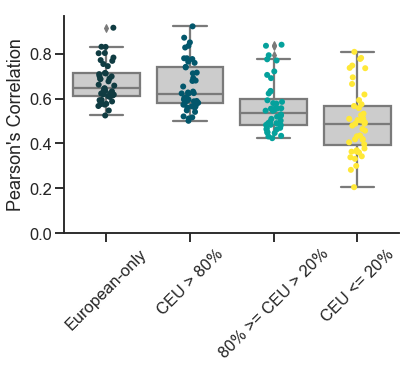

In [19]:
data2 = full_df.loc[:,["test_EUR_corr","ADMIX_high_eur_corr","ADMIX_mid_eur_corr","ADMIX_low_eur_corr"]]
ax = sns.boxplot(data = data2,color=".8")
#ax = sns.boxplot(data = data,palette=my_rgbs)
ax = sns.stripplot(data=data2,jitter=True,palette=my_rgbs,size=6)

ax.set_xticklabels(["European-only","CEU > 80%","80% >= CEU > 20%", "CEU <= 20%"],
                   rotation=45)
ax.set_yticks(np.arange(0,1.0,0.2))
plt.ylabel("Pearson's Correlation")
sns.despine()
plt.show()

In [20]:
data2.shape

(44, 4)

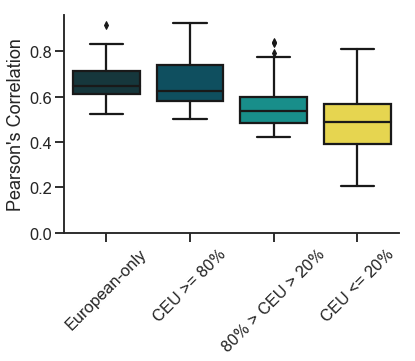

In [21]:
#ax = sns.boxplot(data = data2,color=".8")
ax = sns.boxplot(data = data2,palette=my_rgbs)
#ax = sns.stripplot(data=data2,jitter=True,palette=my_rgbs,size=6)

ax.set_xticklabels(["European-only","CEU >= 80%","80% > CEU > 20%", "CEU <= 20%"],
                   rotation=45)
ax.set_yticks(np.arange(0,1.0,0.2))
plt.ylabel("Pearson's Correlation")
sns.despine()
plt.show()

# Plot maf bins

In [36]:
all_df = pd.DataFrame(columns=["Sim","Pop","G1","G2","G3","G4","G5","G6"])
for file in glob.glob("../results/summary/maf_sims/*"):
    df = pd.read_csv(file,sep="\t")
    all_df = all_df.append(df,ignore_index=True)

In [37]:
df

,Sim,Pop,G1,G2,G3,G4,G5,G6
0,49,Admixed,0.261527,0.450648,0.113833,0.073127,0.055115,0.045749
1,49,European,0.021974,0.653098,0.144813,0.068804,0.061239,0.050072


In [44]:
df_long = pd.melt(all_df.iloc[:,1:],"Pop",var_name="G")

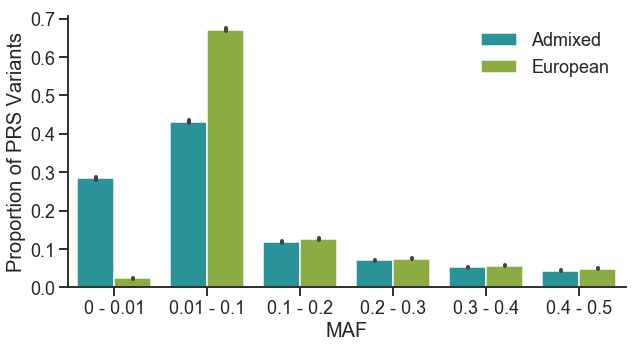

In [80]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="G",hue="Pop",y="value",data=df_long,palette=["#18A3AC","#90BD31"])

plt.xlabel("MAF",fontsize=20)
plt.ylabel("Proportion of PRS Variants",fontsize=20)

ax.set_xticklabels(labels=["0 - 0.01","0.01 - 0.1","0.1 - 0.2","0.2 - 0.3","0.3 - 0.4","0.4 - 0.5"],fontsize=18)
ax.set_yticklabels(labels = np.round(np.arange(0,0.8,0.1),1),fontsize=18)

sns.despine()
plt.legend(frameon=False,fontsize=18)
plt.savefig("/Users/taylorcavazos/Desktop/maf_bars.pdf",type="pdf",
           bbox_inches="tight")
plt.show()

In [38]:
all_df

,Sim,Pop,G1,G2,G3,G4,G5,G6
0,44,Admixed,0.267196,0.429012,0.121252,0.080247,0.059524,0.042769
1,44,European,0.020723,0.643739,0.141975,0.070988,0.072751,0.049824
2,50,Admixed,0.293883,0.414043,0.116178,0.077452,0.049584,0.048860
3,50,European,0.023163,0.646037,0.136084,0.077814,0.065147,0.051755
4,45,Admixed,0.281652,0.429684,0.131282,0.072069,0.048695,0.036619
5,45,European,0.024153,0.678224,0.127386,0.082976,0.040904,0.046358
6,47,Admixed,0.283576,0.431185,0.121414,0.078170,0.046985,0.038669
7,47,European,0.019127,0.675260,0.117256,0.085655,0.056133,0.046570
8,46,Admixed,0.305751,0.418924,0.119109,0.075325,0.043785,0.037106
9,46,European,0.026716,0.688312,0.117625,0.074583,0.052319,0.040445


In [138]:
np.mean(data2["ADMIX_low_eur_corr"])

0.497461788755369

In [139]:
np.mean(data1["ADMIX_low_eur_corr"])

0.4834692837673703

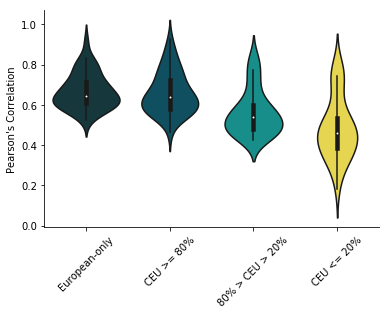

In [24]:
# data2 = full_df.loc[:,["test_EUR_corr","ADMIX_high_eur_corr","ADMIX_mid_eur_corr","ADMIX_low_eur_corr"]]
ax = sns.violinplot(data = data1,palette=my_rgbs)
#ax = sns.boxplot(data = data,palette=my_rgbs)
#ax = sns.stripplot(data=data2,jitter=True,palette=my_rgbs,size=6)

ax.set_xticklabels(["European-only","CEU >= 80%","80% > CEU > 20%", "CEU <= 20%"],
                   rotation=45)
ax.set_yticks(np.arange(0,1.2,0.2))
plt.ylabel("Pearson's Correlation")
sns.despine()
plt.show()

In [15]:
stats.ttest_ind(data1["ADMIX_high_eur_corr"], data1["ADMIX_low_eur_corr"])

Ttest_indResult(statistic=3.9312362731504544, pvalue=0.0002215017671599995)

In [16]:
stats.ttest_ind(data1["ADMIX_high_eur_corr"], data1["ADMIX_mid_eur_corr"])

Ttest_indResult(statistic=2.870682000079218, pvalue=0.0056505206591653985)

In [17]:
stats.ttest_ind(data1["ADMIX_low_eur_corr"], data1["ADMIX_mid_eur_corr"])

Ttest_indResult(statistic=-1.6274934989630512, pvalue=0.10887298856549474)

In [18]:
stats.ttest_ind(data1["test_EUR_corr"], data1["ADMIX_low_eur_corr"])

Ttest_indResult(statistic=4.800465071635748, pvalue=1.091353847098971e-05)

In [19]:
stats.ttest_ind(data2["ADMIX_high_eur_corr"], data2["ADMIX_low_eur_corr"])

Ttest_indResult(statistic=4.3920214499577686, pvalue=4.63858844408327e-05)

In [20]:
stats.ttest_ind(data2["ADMIX_high_eur_corr"], data2["ADMIX_mid_eur_corr"])

Ttest_indResult(statistic=3.182261735132631, pvalue=0.0023154553501685098)

In [21]:
stats.ttest_ind(data2["ADMIX_low_eur_corr"], data2["ADMIX_mid_eur_corr"])

Ttest_indResult(statistic=-1.659047049817655, pvalue=0.10232525864575888)

In [22]:
stats.ttest_ind(data2["test_EUR_corr"], data2["ADMIX_low_eur_corr"])

Ttest_indResult(statistic=4.992129288800119, pvalue=5.442416720169175e-06)

### PRS-Specific Ancestry

____
# Number of Causal Inds Found

In [22]:
num_found = np.loadtxt("../results/summary/causal_inds_identified.txt",dtype=int)

In [27]:
int(np.average(num_found))

15

In [28]:
int(np.std(num_found))

3

In [31]:
(int(np.std(num_found))*2)/1000

0.006

In [30]:
int(np.average(num_found))/1000

0.015

_ _ _
# Quick comparison emprical vs true prs

In [ ]:
import h5py, pandas as pd, numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
sim=1

In [ ]:
true_prs = h5py.File('../data/sim{}/true_prs/prs_m_1000_h2_0.67.hdf5'.format(sim), 'r')
emp_prs = h5py.File('../data/sim{}/emp_prs/emp_prs_m_1000_h2_0.67_ld_CEU.hdf5'.format(sim))
train_test = h5py.File('../data/sim{}/true_prs/train_test_m_1000_h2_0.67.hdf5'.format(sim))
anc = pd.read_csv('../data/sim{}/admixed_data/output/admix_afr_amer.prop.anc'.format(sim),sep="\t",index_col=0)

In [ ]:
train_cases = train_test['train_cases'][()]
train_controls = train_test['train_controls'][()]

In [ ]:
testing = train_test['test_data'][()]

In [ ]:
eur_test, admix_test = [], []
for ind in testing:
    lab = true_prs['labels'][()][ind].astype(str)
    if 'msp' in lab: eur_test.append(ind)
    else: 
        admix_test.append(ind)  
eur_test = np.array(eur_test)
admix_test = np.array(admix_test)

## all correlation

In [ ]:
stats.spearmanr(true_prs['X'][()],emp_prs['X'][()])

## train correlation

In [ ]:
train_true_prs = true_prs['X'][np.append(train_cases,train_controls)]
train_emp_prs = emp_prs['X'][np.append(train_cases,train_controls)]

In [ ]:
stats.spearmanr(train_true_prs,train_emp_prs)

In [ ]:
plt.scatter(train_true_prs,train_emp_prs)

## test correlation European

In [ ]:
test_true_prs_eur = true_prs['X'][eur_test]
test_emp_prs_eur = emp_prs['X'][eur_test]

In [ ]:
stats.spearmanr(test_emp_prs_eur,test_true_prs_eur)

## test correlation Admix

In [ ]:
test_true_prs_admix = true_prs['X'][admix_test]
test_emp_prs_admix = emp_prs['X'][admix_test]
stats.spearmanr(test_emp_prs_admix,test_true_prs_admix)

## test correlation by ancestry prop

In [ ]:
anc_w_ind = anc.reset_index()

In [ ]:
low_eur = list(anc_w_ind[anc_w_ind["Prop_CEU"]<=0.2].index)
mid_eur = list(anc_w_ind[(anc_w_ind["Prop_CEU"]>0.2)&(anc_w_ind["Prop_CEU"]<0.8)].index)
high_eur = list(anc_w_ind[anc_w_ind["Prop_CEU"]>=0.8].index)

In [ ]:
admix_test[low_eur]

In [ ]:
true_prs['X'][list(admix_test[low_eur])]

In [ ]:
stats.spearmanr(true_prs['X'][list(admix_test[low_eur])],emp_prs['X'][list(admix_test[low_eur])])

In [ ]:
stats.spearmanr(true_prs['X'][list(admix_test[mid_eur])],emp_prs['X'][list(admix_test[mid_eur])])

In [ ]:
stats.spearmanr(true_prs['X'][list(admix_test[high_eur])],emp_prs['X'][list(admix_test[high_eur])])

In [ ]:
true_prs.close()
emp_prs.close()
train_test.close()

___
## Need to implement this...

In [ ]:
 import itertools

In [ ]:
ts = msprime.simulate(200,recombination_rate=10,mutation_rate=20,random_seed=1,)

In [ ]:
ts.num_sites

In [ ]:
rand_select1 = np.random.choice(ts.samples(),size=30, replace=False)
ts_1 = ts.simplify(samples=rand_select1,filter_sites=False)

In [ ]:
rand_select2 = np.random.choice(ts_1.samples(),size=30, replace=False)

In [ ]:
small_ts= ts_1.simplify(samples=rand_select2,
                       filter_sites=False,filter_individuals=True)

In [ ]:
focal_vars = np.random.choice(np.arange(small_ts.num_sites),replace=False,size=25)

In [ ]:
var2mut, mut2var = {}, {}
for mut in small_ts.mutations():
    mut2var[mut.id]=mut.site
    var2mut[mut.site]=mut.id

In [ ]:
small_ts_filt= ts_1.simplify(samples=rand_select2,
                       filter_sites=True,filter_individuals=True)

In [ ]:
found_focal_vars = list(set(focal_vars).intersection(var2mut.keys()))

In [ ]:
find_ld_sites(small_ts_filt,found_focal_vars,var2mut,mut2var)

____

## Simulated admixed individuals

Possible tools for admixture simulations
* [admix-simu (C++ and python)](https://github.com/williamslab/admix-simu)
    - 4 years old
* [bnpsd (R package)](https://cran.r-project.org/web/packages/bnpsd/vignettes/bnpsd.pdf)
    - Came out this year
* [admixture-simulation](https://github.com/slowkoni/admixture-simulation)
    - 2 years old

### a: European and African populations for mating

- 5000 Africans and 5000 Europeans
- Will have difficulty with files much larger because have to write data to vcf and takes up lots of storage

### b: Europeans for training

- 100000 Europeans simulated with out-of-africa model
- In tree structure

### c: African Americans

- Have 4000 admixed individuals
- In future may need larger ~10,000 for doing training
- If I don't use large enough base population these people may be too related

In [ ]:
#tree_all = msprime.load("../data/trees/tree_YRI_5e4_CEU_2e6_chr22.hdf5")
sample_map_all = pd.read_csv("../data/trees/CEU_YRI_sample_map.txt",sep="\t",header=None)

In [ ]:
all_data = np.array(tree_all.samples())

In [ ]:
other_samps = np.delete(all_data,mate_samples)

In [ ]:
tree_other = tree_all.simplify(samples = other_samps, filter_sites=False)

In [ ]:
pd.DataFrame(np.array([[3,3,3,3],[1,1,1,1]])).iloc[:,:2]

In [ ]:
tree = msprime.load(path_tree)

In [ ]:
sample_map_all = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/CEU_YRI_sample_map.txt",sep="\t",header=None)

In [ ]:
eur_only = sample_map_all[sample_map_all.iloc[:,1]=="CEU"].index

In [ ]:
new_tree = tree.simplify(samples=eur_only,filter_sites=False)

In [ ]:
import itertools

In [ ]:
list(itertools.islice(new_tree.mutations(),10))

In [ ]:
new_tree.mutations()

In [ ]:
new_tree.num_sites

In [ ]:
list(itertools.islice(new_tree.variants(),10))[0]

In [ ]:
list(itertools.islice(new_tree.mutations(),10))

In [ ]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(m,h2),sep="\t",index_col=0)

In [ ]:
prs = sum_stats[sum_stats["p-value"]<5e-8]

In [ ]:
len(prs)

In [ ]:
mut_sites = []
for mut in new_tree.mutations():
    mut_sites.append(mut.site)

In [ ]:
new_prs = prs.loc[np.intersect1d(mut_sites,prs.index)].reset_index()

In [ ]:
new_prs.shape

In [ ]:
sum_stats.loc[62,"OR"]

In [ ]:
float(new_prs.loc[new_prs["var_id"]==62,"OR"])

In [ ]:
len(mut_sites)

In [ ]:
tree.num_sites

In [ ]:
tree.num_mutations

## Get proportion of local ancestry

In [ ]:
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_sub_CEU_1.95e5.hdf"

In [ ]:
n_sites = msprime.load(path_tree).num_sites

In [ ]:
with open("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer.result") as f:
    pbar = tqdm.tqdm(total=n_sites+1)
    ind = 0
    clumped_prs_vars = np.array(open("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/prs_vars_p_5e-8_r2_0.2.txt").read().splitlines()).astype(int)
    for line in f:
        line_spl = line.split("\t")
        if ind == 0:
            sample_haps = line_spl[2:]
            samples = [sample_haps[i].split(".")[0] for i in range(0,len(sample_haps),2)]
            anc_df = pd.DataFrame(columns=samples)
            counts_CEU = np.zeros(len(samples))
            counts_YRI = np.zeros(len(samples))
        elif ind-1 in clumped_prs_vars:
            haplo_anc = np.array(line_spl[2:]).astype(int)
            YRI_arr = haplo_anc-1
            CEU_arr = np.absolute(1-YRI_arr)
            line_counts_CEU = np.add.reduceat(CEU_arr, np.arange(0, len(CEU_arr), 2))
            #SNP=line_spl[0]+"_"+line_spl[1]            
            anc_df.loc[ind-1,:] = line_counts_CEU
            
        ind+=1
        pbar.update(1)
    anc_df.to_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/CEU_counts_prs_vars.txt",sep="\t")

In [ ]:
anc_df

In [ ]:
prop_anc = pd.read_csv("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer_PRS.prop.anc",
           sep="\t",index_col=0)

In [ ]:
plt.hist(prop_anc["Prop_CEU"])
plt.show()

In [ ]:
prop_anc[prop_anc["Prop_CEU"]<=0.2].shape

In [ ]:
prop_anc[prop_anc["Prop_CEU"]>=0.8].shape

In [ ]:
prop_anc[(prop_anc["Prop_CEU"]<0.8)&(prop_anc["Prop_CEU"]>0.2)].shape

## Calculate True PRSs for all individuals

In [ ]:
import output_true_prs

Assume same causal variants and effect sizes

Average true PRS over a 100 iterations

In [ ]:
f = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/true_prs/prs_m_1000_h2_0.67.hdf5', 'r')

In [ ]:
f.keys()

In [ ]:
f['labels'][()]

In [ ]:
ceu_anc_prop = [1]*(f['G'].shape[0]-prop_anc.shape[0])+list(prop_anc["Prop_CEU"])

In [ ]:
len(ceu_anc_prop)

In [ ]:
plt.scatter(x=f['G'][()],y=ceu_anc_prop)
plt.xlabel("True Polygenic Risk Score",fontsize=14)
plt.ylabel("Proportion European Ancestry",fontsize=14)
plt.show()

## Select Cases and Controls

In [ ]:
import h5py
import seaborn as sns
import numpy as np

In [ ]:
f = h5py.File('../data/sim1/true_prs/train_test_m_1000_h2_0.67.hdf5', 'r')

In [ ]:
f.keys()

In [ ]:
prs_f = h5py.File('../data/sim1/true_prs/prs_m_1000_h2_0.67.hdf5', 'r')

In [ ]:
prs_f.keys()

In [ ]:
labels = prs_f['labels'][()]

In [ ]:
true_prs = prs_f['G'][()]

In [ ]:
sns.distplot(true_prs[f['train_cases'][()]],color="red")
sns.distplot(true_prs[f['train_controls'][()]],color="blue")

In [ ]:
f.close()
prs_f.close()

In [ ]:
data = np.append(f['train_cases'][()],f['train_controls'][()])
data = np.append(data,f['test_data'][()][:50])

In [ ]:
np.sort(data)

In [ ]:
labels[f['train_cases'][()]]

In [ ]:
labels[f['train_controls'][()]]

In [ ]:
labels[f['test_data'][()]]

In [ ]:
sns.distplot(f['G'][()])
plt.vlines(x=np.percentile(f['G'][()],95),ymin=0,ymax=0.5)
plt.show()

In [ ]:
sns.distplot(G+E)
plt.vlines(x=np.percentile(G+E,95),ymin=0,ymax=0.4)
plt.show()

In [ ]:
import numpy as np

In [ ]:
arr = np.array([0,4,3,2])

In [ ]:
arr[np.argsort(arr)][2:]

In [ ]:
sns.distplot(meta_data.loc[eur_train_case,"truePRS"],color="red")
sns.distplot(meta_data.loc[eur_train_control,"truePRS"],color="blue")
plt.show()

In [ ]:
sns.distplot(meta_data.loc[eur_test_case,"truePRS"],color="red")
sns.distplot(meta_data.loc[eur_test_control,"truePRS"],color="blue")
plt.show()

In [ ]:
sns.distplot(meta_data.loc[meta_data.Disease==1,"truePRS"],color="red")
sns.distplot(meta_data.loc[meta_data.Disease==0,"truePRS"],color="blue")
plt.show()

## Perform GWAS with training European samples

#### Calculate MAF EUR

In [ ]:
tree = msprime.load(path_tree)
n_sites = tree.num_sites

#### Perform GWAS

In [ ]:
from statsmodels.stats import multitest

## Calculate Expected PRS for everyone

In [ ]:
from output_emp_prs import *

In [ ]:
tree = msprime.load(path_tree)
n_sites = tree.num_sites

In [ ]:
bonf_p = 0.05/n_sites

In [ ]:
bonf_p

In [ ]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}_fdr.txt".format(m,h2),sep="\t",index_col=0)

In [ ]:
prs_vars = sum_stats[sum_stats["p-value"] < bonf_p].sort_values(by=["p-value"])

In [ ]:
prs_vars.shape

prs_vars.head(1000).tail(1)

ld_struct = find_ld_sites(tree, [229402],r2_threshold=0.2,num_threads=1)

In [ ]:
f = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/emp_prs/emp_prs_m_1000_h2_0.67_LD_ALL.hdf5', 'r')

In [ ]:
f.keys()

In [ ]:
f['labels'][()]

In [ ]:
emp = f['X'][()]
emp_Z = (emp - np.mean(emp))/np.std(emp)

In [ ]:
f_LA = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/emp_prs/emp_prs_m_1000_h2_0.67_LD_ADMIX_UNWEIGHT.hdf5', 'r')
emp_LA = f_LA['X'][()]
emp_Z_LA = (emp_LA - np.mean(emp_LA))/np.std(emp_LA)
LA_only_labels = f_LA['labels'][()].astype(str)

In [ ]:
t = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/true_prs/prs_m_1000_h2_0.67.hdf5', 'r')

In [ ]:
true = t['Zx'][()]

In [ ]:
t['labels'][()]

In [ ]:
emp.shape

In [ ]:
true.shape

In [ ]:
plt.scatter(true,emp_Z)
plt.show()

In [ ]:
train_test = h5py.File("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/train_test_CEU_m_1000_h2_0.67.hdf5")

In [ ]:
train_test.keys()

In [ ]:
training = np.append(train_test["train_controls"][()],train_test["train_cases"][()])
testing = np.append(train_test["test_controls"][()],train_test["test_cases"][()])

In [ ]:
len(train_test["train_controls"][()])

In [ ]:
len(train_test["train_cases"][()])

In [ ]:
training_msp = ["msp_"+str(train) for train in training]
testing_msp = ["msp_"+str(test) for test in testing]

In [ ]:
labels = t['labels'][()].astype(str)

In [ ]:
label_inds = pd.DataFrame(np.arange(0,len(labels)),index = labels)
LA_label_inds = pd.DataFrame(np.arange(0,len(LA_only_labels)),index = LA_only_labels)

In [ ]:
train_inds = label_inds.loc[training_msp,0].values
test_inds = label_inds.loc[testing_msp,0].values

In [ ]:
admix = label_inds.loc[prop_anc.index,0].values
LA_admix = LA_label_inds.loc[prop_anc.index,0].values

In [ ]:
low_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]>0.8].index,0].values
mid1 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.2)&(prop_anc["Prop_CEU"]<=0.4)].index,0].values
mid2 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.4)&(prop_anc["Prop_CEU"]<=0.6)].index,0].values
mid3 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.6)&(prop_anc["Prop_CEU"]<=0.8)].index,0].values
high_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<=0.2].index,0].values

In [ ]:
LA_low_admix = LA_label_inds.loc[prop_anc[prop_anc["Prop_CEU"]>0.8].index,0].values
LA_mid1 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.2)&(prop_anc["Prop_CEU"]<=0.4)].index,0].values
LA_mid2 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.4)&(prop_anc["Prop_CEU"]<=0.6)].index,0].values
LA_mid3 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.6)&(prop_anc["Prop_CEU"]<=0.8)].index,0].values
LA_high_admix = LA_label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<=0.2].index,0].values

In [ ]:
plt.scatter(true[test_inds],emp_Z[test_inds],s=10,color="gray")
plt.scatter(true[low_admix],emp_Z[low_admix],color="red",s=10)
#plt.scatter(true[low_admix],emp_Z_LA[LA_low_admix],color="blue",s=10)
plt.scatter(true[high_admix],emp_Z[high_admix],color="blue",s=10)
#plt.scatter(true[high_admix],emp_Z_LA[LA_high_admix],color="blue",s=10)
#plt.scatter(true[mid_admix],emp_Z[mid_admix],color="orange",s=10)

plt.show()

In [ ]:
stats.pearsonr(true[test_inds],emp_Z[test_inds])

CEU > 0.8

In [ ]:
len(low_admix)

In [ ]:
stats.pearsonr(true[low_admix],emp_Z[low_admix])

In [ ]:
stats.pearsonr(true[low_admix],emp_Z_LA[LA_low_admix])

CEU <= 0.2

In [ ]:
len(high_admix)


In [ ]:
stats.pearsonr(true[high_admix],emp_Z[high_admix])

In [ ]:
stats.pearsonr(true[high_admix],emp_Z_LA[LA_high_admix])

0.2 < CEU <= 0.4

In [ ]:
stats.pearsonr(true[mid1],emp_Z[mid1])

0.4 < CEU <= 0.6

In [ ]:
stats.pearsonr(true[mid2],emp_Z[mid2])

0.6 < CEU <= 0.8

In [ ]:
stats.pearsonr(true[mid3],emp_Z[mid3])

In [ ]:
low_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<0.2].index,0].values

In [ ]:
admix = label_inds.loc[prop_anc.index,0].values

### a: Using European GWAS

### b: Using Local-Ancestry Specific Approach (relies on significant SNPs from European GWAS)

## Calculate AUCs and compare between approaches

In [ ]:
clumped_prs_vars = np.array(open("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/prs_vars_p_5e-8_r2_0.2.txt").read().splitlines()).astype(int)

In [ ]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(m,h2),sep="\t",index_col=0)

In [ ]:
prs_vars = sum_stats.loc[clumped_prs_vars,:]

In [ ]:
sum_stats.loc[1488,:]

In [ ]:
set(causal_stats.index).intersection(set(prs_vars.index))

In [ ]:
causal_stats = sum_stats.reindex(causal_inds).dropna(how="all")
causal_stats[causal_stats["p-value"]<5e-8]

In [ ]:
prs_vars.sort_index()

In [ ]:
vcf_file = "/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer.query.vcf"

In [ ]:
afs = []
with open(vcf_file) as f:
    ind=0
    for line in f:
        if line[0] != "#":
            if ind in clumped_prs_vars:
                data = line.split("\t")[9:]
                genotype = np.array([np.array(hap.split("|")).astype(int).sum() for hap in data])
                af = genotype.sum()/(2*4000)
                afs.append(af)
            ind+=1

In [ ]:
(np.array(afs)<0.01).sum()

In [ ]:
0.615194/0.244875

In [ ]:
np.log(0.567920)/0.000625

In [ ]:
np.log(0.567920)

In [ ]:
causal_inds = np.linspace(0, n_sites, m, dtype=int,endpoint=False)

In [ ]:
causal_inds